# Course lecture
[2 - Random Forest Deep Dive](http://course18.fast.ai/lessonsml1/lesson2.html)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/bogeholm/fastai-intro-to-ml/blob/master/2-random-forest-deep-dive.ipynb)

# Notes
## Lessons from last
- Learn the metric (RMSE log sale price)
- All columns should be _numbers_
  - `datetime` -> `bool`eans (`dayofweek`, `dayofyear`, ...)
  - All string values must be categorized
- Missing values replaced by median
- Additional boolean column `f'{colname}_na'` added to indicate missing values

## This time
- Discussion of [$R^2$](https://en.wikipedia.org/wiki/Coefficient_of_determination) in the context of [overfitting](https://en.wikipedia.org/wiki/Overfitting) and the [validation set](https://en.wikipedia.org/wiki/Training,_validation,_and_test_sets)
- Validation sets vs. training sets - **test set** is reserved for validating model after training and choosing hyperparameters on the **validation set** (*unclear which set is used for which - ask Google*)
- If the test set represents a different time period than the training set, so should the validation set

### Speeding things up
- Choose a smaller subset of the data for interactive use
- Build model with sinle tree (32:00)

### Random Forests
- A tree consists of a set of binary decisions
- How do you split the trees?
   - Eg. try every possible split of every possible value, and find the one with the best weighted average of MSE in the two groups
 - The tree is finished when there is only one element in each leaf node (default `scikit-learn` behavior)
- A *Forest* is made of *Trees*. The Forest is made of Trees by Bagging. See "Bag of Little Bootstraps", a method of *ensembling*.
- Method: Create a largish set of trees, that massively overfits on a random subset of the data. They all have random errors. What is the average of a set of random errors?
- `scikit-learn` pick random subsets with replacement, ie. Bootstrapping.
- The goal of Random Forests is to come up with 'predictive, but poorly correlated trees' (find link to original 1990's paper)
- Un-correlated trees is more important than accurate trees - see `scikit-learn`'s `XtraTreesRegresor`
- When turning off bootstrapping (`bootstrap=False`), the shallow tree will be contained in a deeper tree

### Hyperparameters
#### Number of trees
- `scikit-learn` parameter `n_estimators`

#### Out-of-bag score
- At each level, use unused rows a validation sets (`oob_score=True` in `scikit-learn`) (1:12:00)

#### Subsampling
- If you pick a random subset for each tree, it doesn't matter how much data you have

#### Growing trees less deeply
- `scikit-learn` parameter `min_samples_leaf` - determines the minimum number of data points in the leaves. `3` suggested.

#### Maximum number of features
- `scikit-learn` parameter `max_features` The less correlated your trees are, the better. Takes a different subset of columns at each split point. Try `0.5`, `sqrt` or `log2`

## Implementation plan
- [x] Q: Can you fit on a DataFrame with categories added, but columns still in place? A: [Not this way at least](https://github.com/bogeholm/dataworks/blob/master/dev/jupyter/df-categories-and-codes.ipynb)
- [x] Split data to smaller, 'interactive' set
- [x] Draw a single tree
- [x] Run the `RandomForestRegressor`, see predictions of the single trees ('`estimators`') (51:16)
- [ ] Define `print_score()` with `oob_score`, from output of `model.score(X, y)`
- [x] Predict with each tree in a Forest, and compare with the mean (1:05)
- [x] Plot metrics of one tree, then average of two trees, then ... (1:06:55)
- [x] Run with 20, 30, 40 trees (1:08:10)
- <s>Look at `set_rf_samples` and `reset_rf_samples` (from `fast.ai`, a "horrible hack") (1:16:00 and 1:19)</s>
- [ ] Compare results with [`ExtraTreesRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html)
- [x] Move `get_basepath()` to separate file 
- [x] Save preprocessed data for next time

### Further ideas
- Use [`HistGradientBoostingRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html#sklearn.ensemble.HistGradientBoostingRegressor)

# Tips
## Notebook tips
- `?` to view documentation of imported functions
- `??` to view source code of imported functions

## Python tips
- `print(f'{variable}_string')`
- Saving with [`to_feather`](https://github.com/wesm/feather/tree/master/python)

## ML Tips
- "Most people run all of their models, on all of their data, all of the time" (around 1:20). This is pointless. Do most of the modelling on a reasonably large subset to preserve interactivity. Then let the machine go full data overnight while you're sleeping.

# Setup
## Install [dataworks](https://github.com/bogeholm/dataworks)

In [1]:
# Uncomment to install utilities:
#!pip install --upgrade --quiet git+git://github.com/bogeholm/dataworks.git

## Get [notebook utilities file](https://github.com/bogeholm/fastai-intro-to-ml/blob/master/notebookutils.py) - only relevant if in Colab

In [2]:
# Uncomment to fetch notebook utilities
#!curl --proto '=https' --tlsv1.2 -sSf --output notebookutils.py 'https://raw.githubusercontent.com/bogeholm/fastai-intro-to-ml/master/notebookutils.py'

## Imports

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys

from dataworks.df_utils import (add_datefields, add_nan_columns, categorize_df, inspect_df, 
    numeric_nans, summarize_df,)

from notebookutils import get_basepath, rmse

from IPython.display import display, set_matplotlib_formats
from IPython.core.pylabtools import figsize

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor#, HistGradientBoostingRegressor
from sklearn.tree import plot_tree
from sklearn import metrics
from typing import Optional, List, Tuple

pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)

%matplotlib inline
#set_matplotlib_formats('svg')
set_matplotlib_formats('png')
# https://matplotlib.org/3.1.1/gallery/style_sheets/style_sheets_reference.html
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 16})

## Mount Google Drive (for [Colab](https://colab.research.google.com/) integration)

In [4]:
BASEPATH = get_basepath()

In [5]:
DATAPATH = os.path.join(BASEPATH, 'bulldozers')
print(f'DATAPATH: {DATAPATH}')

DATAPATH: C:\Users\tbm\Documents\machinelearning\fastai-intro-to-ml\data\bulldozers


## Notebook utilities

In [6]:
def display_allrows(df):
    """ Override max rows and display them all
    """
    with pd.option_context('display.max_rows', len(df)):
            display(df)

# Start learning ...

In [7]:
filename = os.path.join(DATAPATH, 'Train.zip')
df_raw = pd.read_csv(filename, low_memory=False, parse_dates=['saledate'])

In [8]:
df_raw.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000,999089,3157,121,...,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000,117657,77,121,...,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000,434808,7009,121,...,NaN,NaN,NaN,NaN,NaN
3,1139251,38500,1026470,332,121,...,NaN,NaN,NaN,NaN,NaN
4,1139253,11000,1057373,17311,121,...,NaN,NaN,NaN,NaN,NaN


## Preprocessing
Essentially a summary of steps in [1-intro-to-random-forests](1-intro-to-random-forests.ipynb), but excluding the 'NaN indicator' columns

### Log sale price

In [9]:
df_proc = df_raw.copy(deep=True)
if 'SalePrice' in df_proc.columns:
    df_proc['LogSalePrice'] = np.log(df_proc['SalePrice'])
    df_proc.drop(columns=['SalePrice'], inplace=True)

### Saledate

In [10]:
if 'saledate' in df_proc.columns:
    df_proc = add_datefields(df_proc, 'saledate', drop_original=True)

### Numerical nulls

In [11]:
df_proc['auctioneerID'] = df_proc['auctioneerID'].fillna(
    df_proc['auctioneerID'].max() + 1
)

df_proc['MachineHoursCurrentMeter'] = df_proc['MachineHoursCurrentMeter'].fillna(
    df_proc['MachineHoursCurrentMeter'].median()
)

### Categorize

In [12]:
(df_cats, catcodes) = categorize_df(df_proc)

In [13]:
summarize_df(df_cats)

,type,ncols,ncols_w_nans,n_nans,n_total,nan_frac
0,bool,4,0,0,1604500,0.0
1,float64,3,0,0,1203375,0.0
2,int16,4,0,0,1604500,0.0
3,int64,9,0,0,3610125,0.0
4,int8,40,0,0,16045000,0.0


### Save for next time

In [14]:
proc_filename = os.path.join(DATAPATH, 'Train-Preprocessed.zip')
codes_filename = os.path.join(DATAPATH, 'Train-Codes.zip')

# Uncomment to save files
#df_cats.to_csv(proc_filename, compression='zip')
#catcodes.to_csv(codes_filename, compression='zip')

## Split into train / test

In [15]:
def split_dataset(df: pd.DataFrame, column: str, indices: Optional[List[bool]]=None, 
                  fromto: Optional[Tuple[int, int]]=None, length: Optional[int]=None) -> Tuple[pd.DataFrame, np.array]:
    """ Split DataFrame into dependent and independent variables. 
        'indices' overrides 'fromto', 'fromto' overrides 'length'
    """
    if indices is not None:
        resdf = df[indices].copy(deep=True)
    elif fromto is not None:
        (low, up) = fromto
        resdf = df[low:up].copy(deep=True)
    elif length is not None:
        resdf = df[0:length].copy(deep=True)
    else:
        resdf = df.copy(deep=True)
    
    # dependent variable
    y_vals = np.array(resdf[column].values)
    # independent variable(s)
    resdf.drop(columns=column, inplace=True)
    
    return resdf, y_vals

In [16]:
X_train, y_train = split_dataset(df_cats, 'LogSalePrice', fromto=(0, 10_000))
X_test, y_test = split_dataset(df_cats, 'LogSalePrice', fromto=(10_000, 15_000))

## Dive into Random Forests

### Draw a single tree
See scikit-learn docs [here](https://scikit-learn.org/stable/auto_examples/tree/plot_iris_dtc.html#sphx-glr-auto-examples-tree-plot-iris-dtc-py) and [here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html?highlight=plot_tree)

In [17]:
model1 = RandomForestRegressor(max_depth=3, n_estimators=10, n_jobs=-1)
%time model1.fit(X_train, y_train)

Wall time: 262 ms


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [18]:
#dir(model1)

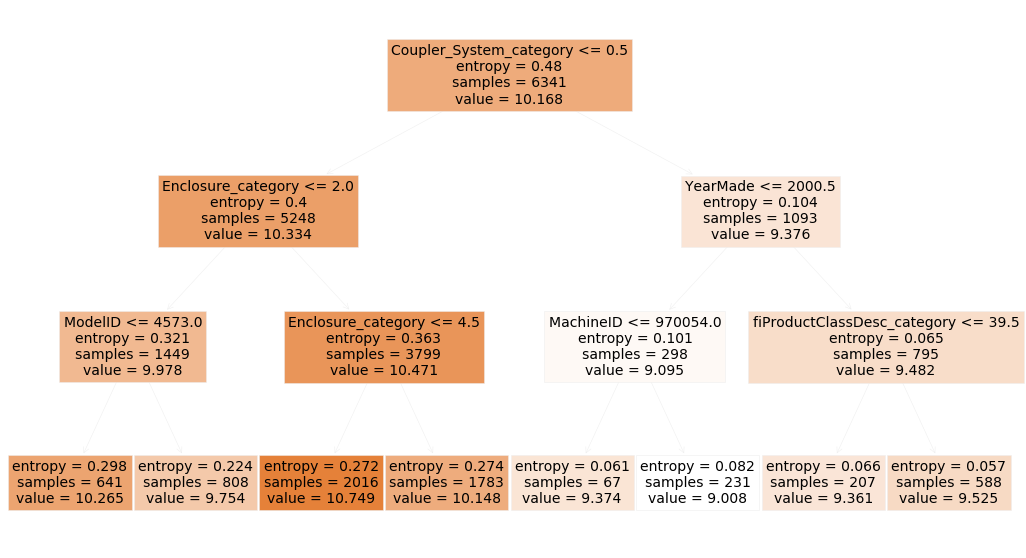

In [19]:
figsize(18, 10)
fig, ax = plt.subplots(1, 1)

x = plot_tree(model1.estimators_[1], 
              feature_names=X_train.columns.values,
              #rotate=True, # Doesn't work
              filled=True,
              fontsize=14,
              max_depth=3,
              ax=ax)

### Compare predictions of the individual trees

In [20]:
def print_score():
    """ Pass
    """

In [21]:
model2 = RandomForestRegressor(n_estimators=10, n_jobs=-1)
%time model2.fit(X_train, y_train)

Wall time: 763 ms


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [22]:
#dir(model2)

In [23]:
#dir(model2.estimators_[0])

In [24]:
# Predict using the whole tree
y_preds2 = model2.predict(X_test)

In [25]:
rmse(y_test, y_preds2)

0.30527899027848193

In [26]:
predictions2 = np.array([est.predict(X_test) for est in model2.estimators_])

In [27]:
np.shape(predictions2)

(10, 5000)

In [28]:
rmse(y_test, np.mean(predictions2, axis=0))

0.30527899027848193

In [29]:
# Use first a single tree for prediction, then add one more, untill we have used all
for idx in range(np.shape(predictions2)[0]):
    pass
    #preds_subset = predictions2[:idx, :]
    #preds_mean = np.mean(preds_subset, axis=0)
    #print(f"idx: {idx}")

In [30]:
def predict_trees_cumulative(model, Xdata):
    """ Predict using each estimator in model. 
        Return predictions using successively more estimators
    """
    preds = np.array([est.predict(Xdata) for est in model.estimators_])
    res = np.zeros((model.n_estimators, np.shape(Xdata)[0]))
    
    # First estimator - nothing to average over
    res[0, :] = preds[0, :]
    
    # Renmaining estimators
    for idx in range(1, model.n_estimators):
        res[idx, :] = np.mean(preds[0:idx+1, :], axis=0)
        
    return res

In [31]:
x = predict_trees_cumulative(model2, X_train)

In [32]:
preds_trees_avg = [rmse(y_train, x[idx, :]) for idx in range(np.shape(x)[0])]

Text(0, 0.5, 'RMSE')

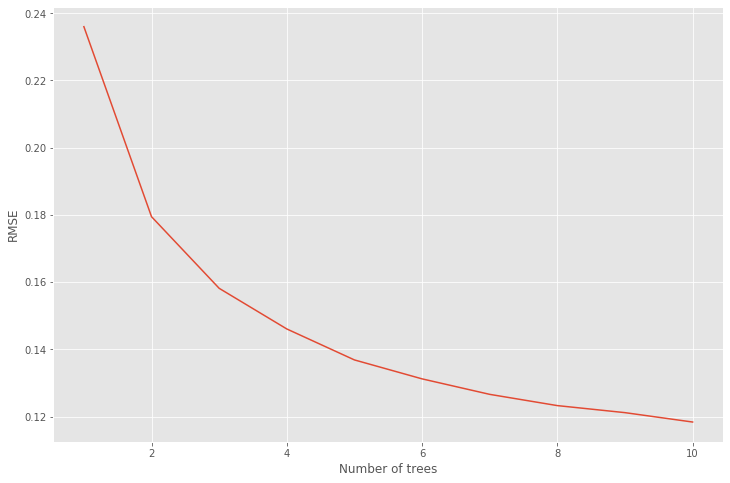

In [33]:
figsize(12, 8)
fig, ax = plt.subplots(1, 1)

xax = np.arange(1, np.shape(x)[0]+1)

ax.plot(xax, preds_trees_avg)

ax.set_xlabel('Number of trees')
ax.set_ylabel('RMSE')

### Use OOB score

In [34]:
model_40 = RandomForestRegressor(n_estimators=40, n_jobs=-1)
model_40_oob = RandomForestRegressor(n_estimators=40, oob_score=True, n_jobs=-1)

In [35]:
%time _ = model_40.fit(X_train, y_train)
%time _ = model_40_oob.fit(X_train, y_train)

Wall time: 2.29 s
Wall time: 2.36 s


In [36]:
preds_40 = predict_trees_cumulative(model_40, X_train)
preds_40_oob = predict_trees_cumulative(model_40_oob, X_train)

In [37]:
def rmse_rowwise(predictions, y_vals):
    """ Apply RMSE rowwise
    """
    # columns of predictions correspond to entries in y_vals
    assert np.shape(predictions)[1] == np.shape(y_vals)[0]
    # vector
    assert len(np.shape(y_vals)) == 1
    
    return np.array([rmse(y_vals, predictions[idx, :]) for idx in range(np.shape(predictions)[0])])
    

In [38]:
preds_40_rmse = rmse_rowwise(preds_40, y_train)
preds_40_rmse_oob = rmse_rowwise(preds_40_oob, y_train)

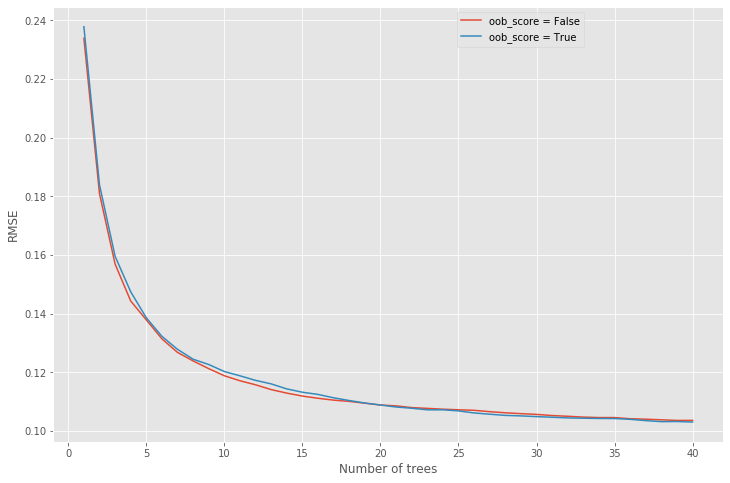

In [39]:
figsize(12, 8)
fig, ax = plt.subplots(1, 1)

xax = np.arange(1, np.shape(preds_40_rmse)[0]+1)

ax.plot(xax, preds_40_rmse, label='oob_score = False')
ax.plot(xax, preds_40_rmse_oob, label='oob_score = True')

ax.set_xlabel('Number of trees')
ax.set_ylabel('RMSE')

ax.legend()
ax.get_legend().set_bbox_to_anchor((0.8, 1))

### Same on test data

In [40]:
preds_40_test = predict_trees_cumulative(model_40, X_test)
preds_40_oob_test = predict_trees_cumulative(model_40_oob, X_test)

In [41]:
preds_40_rmse_test = rmse_rowwise(preds_40_test, y_test)
preds_40_rmse_oob_test = rmse_rowwise(preds_40_oob_test, y_test)

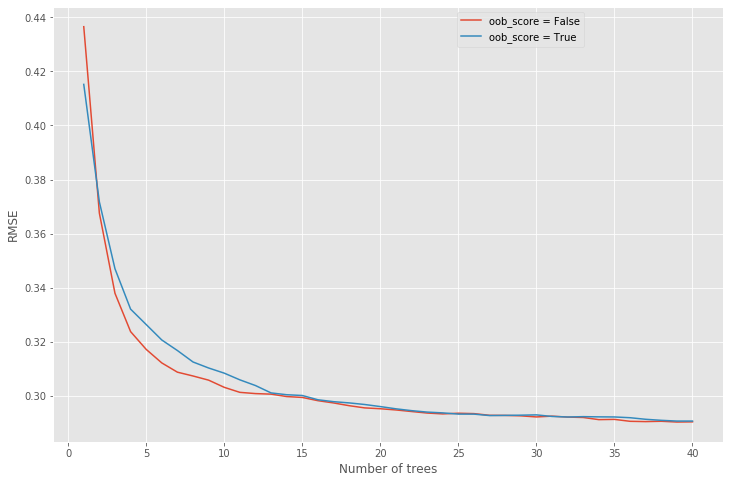

In [42]:
figsize(12, 8)
fig, ax = plt.subplots(1, 1)

xax = np.arange(1, np.shape(preds_40_rmse)[0]+1)

ax.plot(xax, preds_40_rmse_test, label='oob_score = False')
ax.plot(xax, preds_40_rmse_oob_test, label='oob_score = True')

ax.set_xlabel('Number of trees')
ax.set_ylabel('RMSE')

ax.legend()
ax.get_legend().set_bbox_to_anchor((0.8, 1))